In [1]:
import torch
import numpy as np
import torch.nn as nn
from torch.nn.modules.loss import MSELoss
from torch.utils.data import dataloader
import utils
from arguments import parse_args
import torch.optim as optim
import torch.utils.data as data

import torchvision
import torchvision.transforms as T
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tqdm

import wandb
import cv2
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Dataset
import os
from sampling import DelaunayTriangulationBlur
from PIL import Image
import random
import torch
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.autograd import Variable
import numba as nb
from torchvision.transforms import ToTensor, ToPILImage

from IPython.display import clear_output as clear

%matplotlib inline
%load_ext autoreload
%autoreload 2

class TrainDataset_PictureOnly(data.Dataset):
    def __init__(self, args):
        self.args = args
        self.root_path = os.path.join(args.data_root, 'train')
        self.img_list = os.listdir(self.root_path)
        try:
            self.img_list.remove('.DS_Store')
        except:
            pass
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.root_path, self.img_list[idx])
        img_raw = Image.open(img_path)
        img = img_raw.resize((256, 256))
        img = ToTensor()(img)
        img = torch.cat((img, torch.ones((1, 256, 256))), dim=0)
        return img
    
    def __len__(self):
        return len(self.img_list)

In [11]:
args = parse_args( [ "--alg", "MAE"
                   , "--description", "mae-finetune-1000pts-1e-3"
                   , "--lr", "1e-3"
                   , "--epoch", "20"
                   , '--data_root', 'data/celeba'
                   , '--batch_size', '1'
                   , '--point_num', '1000'
                   , '--method', 'center'
                   , '--img_width', '256'
                   , '--img_height', '256'
                   , '--img_size', '256'
                   ])

In [3]:
wandb.init(project=args.description, entity="purewhite2019")
wandb.config = {
  "args" : args,
  "seed" : 31415926
}

# Training Preparation
utils.set_seed_everywhere(31415926)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

train_dataset = TrainDataset_PictureOnly(args)
train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=args.batch_size,
                                shuffle=True,
                                num_workers=args.num_workers,
                                pin_memory=True,
                                drop_last=True)

loss_function = nn.MSELoss()

# loss_function = lambda img_gt, img_pred : -utils.psnr(img_gt, img_pred) - utils.ssim(img_gt, img_pred)

from models.vit import ViT
from models.mae import MAE

img_size, patch_size = (256, 256), (16, 16)

# encoder = ViT(img_size, patch_size, depth=12, dim=768, mlp_dim=3072, num_heads=12) # ViT-B/16
# encoder = ViT(img_size, patch_size, depth=24, dim=1024, mlp_dim=4096, num_heads=16) # ViT-L/16 (Default in MAE paper)
# encoder = ViT(img_size, patch_size, depth=32, dim=1280, mlp_dim=5120, num_heads=16) # ViT-H/16
encoder = ViT(img_size, patch_size, depth=6, dim=512, mlp_dim=768, num_heads=8, channels=4) # Simple

# model = MAE(encoder, decoder_depth=8, decoder_dim=512, mask_ratio=0.75) # (Default in MAE paper)
model = MAE(encoder, decoder_depth=6, decoder_dim=512, mask_ratio=0.75)
model.to(device)

optimizer = optim.RAdam(params=model.parameters(),lr=args.lr)
scheduler = optim.lr_scheduler.StepLR(optimizer,step_size=1000,gamma = 0.5)

e = 0

cuda:0


In [9]:
model.load_state_dict(torch.load('/home/purewhite/workspace/cg-proj/NUG-DLSS/logs/MAE_mae_pretrain_piconly_12.pth'))

<All keys matched successfully>

In [5]:
print(len(train_loader))

400


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


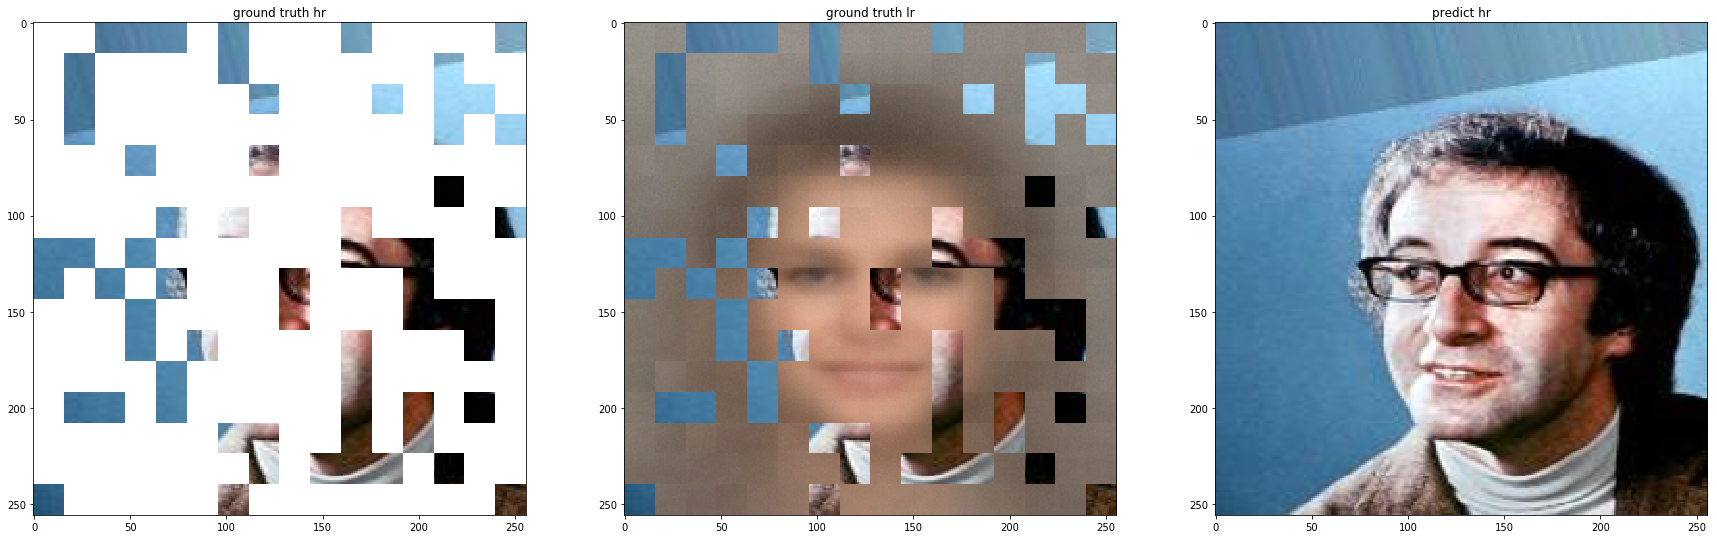

epoch: 19 | iter: 399/400 | loss: 0.036160148680210114: 100%|██████████| 400/400 [01:22<00:00,  4.85it/s]


In [5]:
# Self-supervised pretrain

import random
# Start training
lr_list = []
model.train()
wandb.watch(model)

# for _ in range(800): # Default setting in MAE paper
for _ in range(args.epoch):
    idx = random.randint(0, len(train_dataset)-1)
    img = train_dataset[idx].unsqueeze(0).to(device)
    
    utils.save_model(model, e, args)
    clear()
    recons_img, patches_to_img = model.predict(img)
    recons_img = recons_img[0].permute(1, 2, 0).cpu().numpy()
    patches_to_img = patches_to_img[0].permute(1, 2, 0).cpu().numpy()
    img_gt = img[0].permute(1, 2, 0).cpu().numpy()
    utils.show_gt_and_pred(img_hr=patches_to_img, img_lr=recons_img, pred_hr=img_gt, figsize=(30, 30))
    
    loop = tqdm.tqdm(train_loader)
    for idx, img in enumerate(loop):
        
        img = img.to(device)
        loss = model(img)
            
        wandb.log({"loss": loss})
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        lr_list.append(optimizer.state_dict()['param_groups'][0]['lr'])
        
        loop.set_description(f"epoch: {e} | iter: {idx}/{len(train_dataset)} | loss: {loss.item()}")
    e += 1

In [12]:

from sampling.triangulation_blur import DelaunayTriangulationBlur_4Channel
class TrainDataset_4Channel(Dataset):
    def __init__(self, args):
        self.args = args
        self.root_path = os.path.join(args.data_root, 'train')
        self.img_list = os.listdir(self.root_path)
        try:
            self.img_list.remove('.DS_Store')
        except:
            pass
        self.method = args.method
        self.transform_on_hr = self.get_transform('hr')
        self.transform_on_lr = self.get_transform('lr')

    
    def get_transform(self, target):
        if target=='lr':
            trans = transforms.Compose( 
                [transforms.Resize((self.args.img_width,self.args.img_height))]
                # [transforms.CenterCrop((self.args.img_width,self.args.img_height))]
                )
        elif target=='hr':
            trans = transforms.Compose( 
                [transforms.Resize((self.args.img_width,self.args.img_height))]
                # [transforms.CenterCrop((self.args.img_width,self.args.img_height))]
                )
        else:
            raise Exception('Transform not supported.')
        return trans

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_path, self.img_list[idx])
        img_pair = dict()

        img_hr = Image.open(img_path)
        img_lr = self.transform_on_lr(img_hr)
        
        img_hr= np.array(self.transform_on_hr(img_hr))
        img_pair['hr'] = torch.tensor(img_hr, dtype=torch.float32)

        img_lr = DelaunayTriangulationBlur_4Channel(np.array(img_lr), \
            self.args.point_num, self.args.method)
        img_pair['lr'] = torch.tensor(np.array(img_lr), dtype=torch.float32)
        
        img_pair['hr'] /= 255
        # img_pair['lr'] /= 255 # Moved to DelaunayTriangulationBlur_4Channel

        return img_pair
    
    def __len__(self):
        return len(self.img_list)

normal_train_dataset = TrainDataset_4Channel(args)
normal_train_loader = data.DataLoader(dataset=normal_train_dataset,
                                batch_size=args.batch_size,
                                shuffle=True,
                                num_workers=args.num_workers,
                                pin_memory=True,
                                drop_last=True,
                                collate_fn=utils.collect_function,)

center


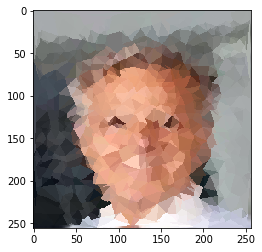

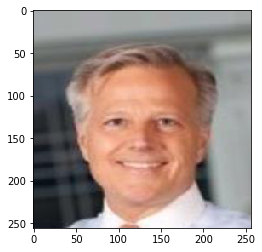

In [13]:

img_pair = normal_train_dataset[0]
img_lr = img_pair['lr']
img_hr = img_pair['hr']

print(args.method)

plt.figure(1)
plt.imshow(img_lr[:,:,:-1])
plt.figure(2)
plt.imshow(img_hr)
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


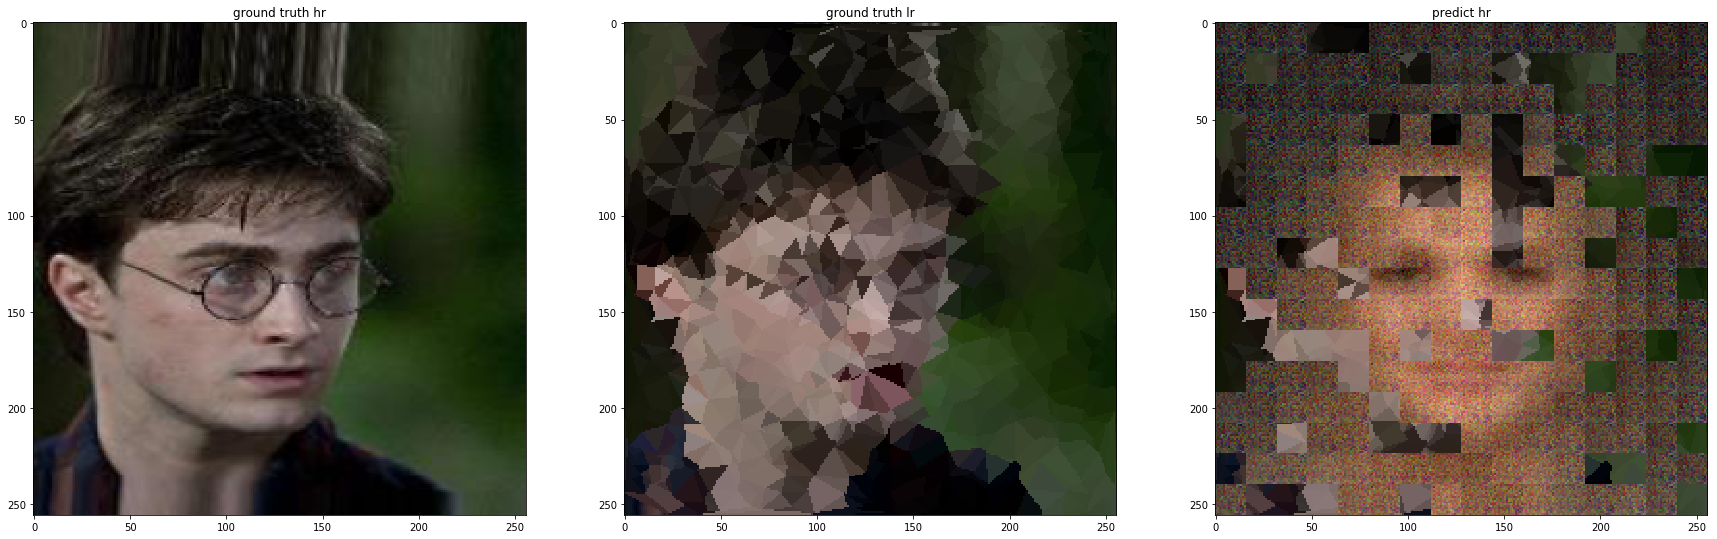

In [21]:
# normal_train_dataset.args.point_num = 1000
idx = random.randint(0, len(normal_train_dataset)-1)
img_pair = utils.collect_function([normal_train_dataset[idx]])

model.eval()
clear()
with torch.no_grad():
    output = model.predict(img_pair['lr'].to(device))[0]
    img_pred = output.permute(0, 2, 3, 1).cpu().numpy()[:, :, :, :-1]

img_lr = img_pair['lr'].permute(0, 2, 3, 1).cpu().numpy()[:, :, :, :-1]
img_gt = img_pair['hr'].permute(0, 2, 3, 1).cpu().numpy()
utils.show_gt_and_pred(img_hr=img_gt[0], img_lr=img_lr[0], pred_hr=img_pred[0], figsize=(30, 30))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


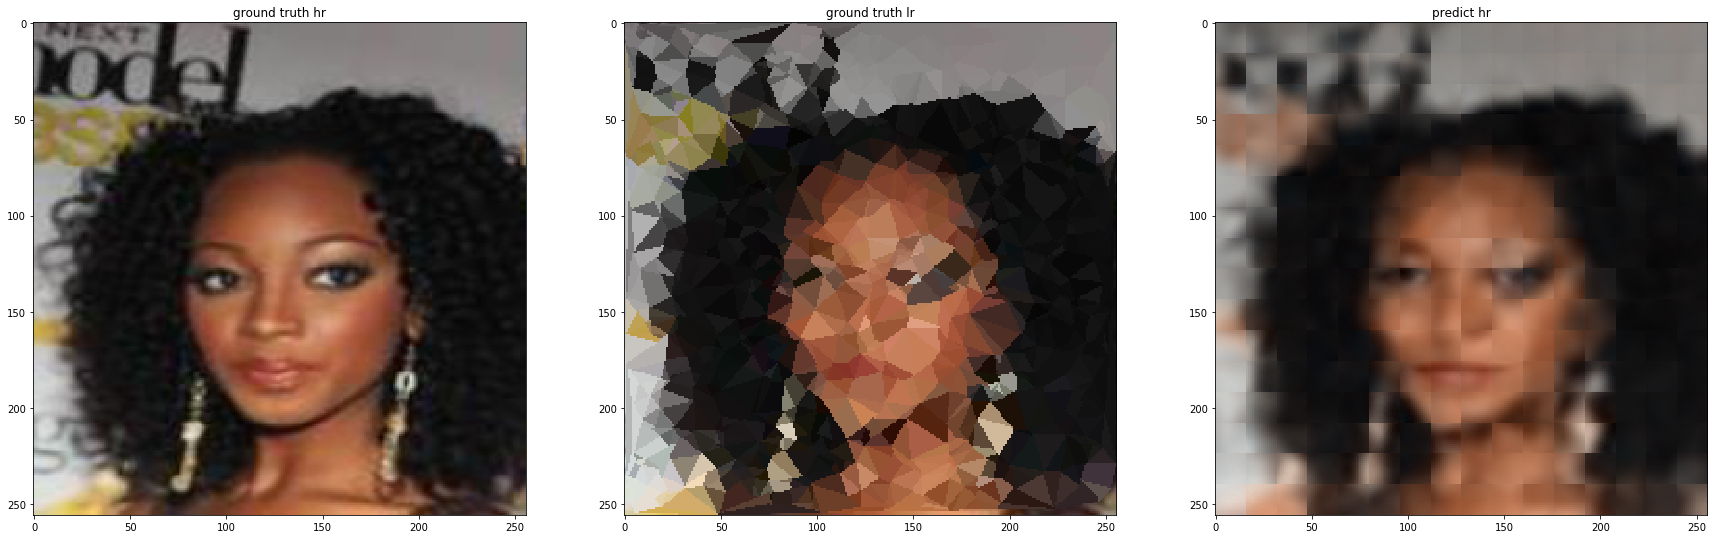

epoch: 19 | iter: 399/400 | loss: -0.7233594655990601: 100%|██████████| 400/400 [01:57<00:00,  3.40it/s]


In [22]:

# for _ in range(800): # Default setting in MAE paper
optimizer.zero_grad()

model.train()
for _ in range(args.epoch):
    idx = random.randint(0, len(normal_train_dataset)-1)
    img_pair = utils.collect_function([normal_train_dataset[idx]])

    model.eval()
    clear()
    with torch.no_grad():
        output = model.forward_nomask(img_pair['lr'].to(device))
        img_pred = output.permute(0, 2, 3, 1).cpu().numpy()[:, :, :, :-1]

    img_lr = img_pair['lr'].permute(0, 2, 3, 1).cpu().numpy()[:, :, :, :-1]
    img_hr = img_pair['hr'].permute(0, 2, 3, 1).cpu().numpy()
    utils.show_gt_and_pred(img_hr=img_hr[0], img_lr=img_lr[0], pred_hr=img_pred[0], figsize=(30, 30))
    
    tot_mse = 0
    tot_psnr = 0
    tot_ssim = 0

    tot_lr_mse = 0
    tot_lr_psnr = 0
    tot_lr_ssim = 0
    
    model.train()
    loop = tqdm.tqdm(normal_train_loader)
    for idx, img_pair in enumerate(loop):
        
        x = img_pair['lr'].to(device)
        output = model.forward_nomask(x)
        
        img_pred = output.permute(0, 2, 3, 1)[:, :, :, :-1].permute(0, 3, 1, 2).to(device)
        img_lr = img_pair['lr'].permute(0, 2, 3, 1)[:, :, :, :-1].permute(0, 3, 1, 2).to(device)
        img_hr = img_pair['hr'].to(device)
        
        mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_pred.reshape((img_hr.shape[0], -1)))
        psnr = utils.psnr(img_hr, img_pred)
        ssim = utils.ssim(img_hr, img_pred)
        loss = -psnr/300 - ssim + mse
        
        tot_mse += mse
        tot_psnr += psnr
        tot_ssim += ssim
        
        lr_psnr = utils.psnr(img_hr, img_lr)
        lr_ssim = utils.ssim(img_hr, img_lr)
        lr_mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_lr.reshape((img_hr.shape[0], -1)))
            
        tot_lr_mse += lr_mse
        tot_lr_psnr += lr_psnr
        tot_lr_ssim += lr_ssim
        
        loss = -psnr/300 - ssim + mse
            
        wandb.log({"psnr improvement": (psnr-lr_psnr)*100/lr_psnr})
        wandb.log({"ssim improvement": (ssim-lr_ssim)*100/lr_ssim})
        wandb.log({"mse improvement": (lr_mse-mse)*100/lr_mse})
        wandb.log({"psnr": psnr})
        wandb.log({"ssim": ssim})
        wandb.log({"mse": mse})
        wandb.log({"loss": loss})
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        loop.set_description(f"epoch: {e} | iter: {idx}/{len(train_dataset)} | loss: {loss.item()}")
    
    e += 1
    utils.save_model(model, e, args)
    

In [12]:
from sampling.triangulation_blur import DelaunayTriangulationBlur_4Channel
class TestDataset_4Channel(Dataset):
    def __init__(self, args):
        self.args = args
        self.root_path = os.path.join(args.data_root, 'test')
        self.img_list = os.listdir(self.root_path)
        try:
            self.img_list.remove('.DS_Store')
        except:
            pass
        self.method = args.method
        self.transform_on_hr = self.get_transform('hr')
        self.transform_on_lr = self.get_transform('lr')

    
    def get_transform(self, target):
        if target=='lr':
            trans = transforms.Compose( 
                [transforms.Resize((self.args.img_width,self.args.img_height))]
                # [transforms.CenterCrop((self.args.img_width,self.args.img_height))]
                )
        elif target=='hr':
            trans = transforms.Compose( 
                [transforms.Resize((self.args.img_width,self.args.img_height))]
                # [transforms.CenterCrop((self.args.img_width,self.args.img_height))]
                )
        else:
            raise Exception('Transform not supported.')
        return trans

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_path, self.img_list[idx])
        img_pair = dict()

        img_hr = Image.open(img_path)
        img_lr = self.transform_on_lr(img_hr)
        
        img_hr= np.array(self.transform_on_hr(img_hr))
        img_pair['hr'] = torch.tensor(img_hr, dtype=torch.float32)

        img_lr = DelaunayTriangulationBlur_4Channel(np.array(img_lr), \
            self.args.point_num, self.args.method)
        img_pair['lr'] = torch.tensor(np.array(img_lr), dtype=torch.float32)
        
        img_pair['hr'] /= 255
        # img_pair['lr'] /= 255 # Moved to DelaunayTriangulationBlur_4Channel

        return img_pair
    
    def __len__(self):
        return len(self.img_list)

normal_test_dataset = TestDataset_4Channel(args)
normal_test_loader = data.DataLoader(dataset=normal_test_dataset,
                                batch_size=args.batch_size,
                                shuffle=True,
                                num_workers=args.num_workers,
                                pin_memory=True,
                                drop_last=True,
                                collate_fn=utils.collect_function,)

torch.Size([1, 4, 256, 256]) torch.Size([1, 3, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


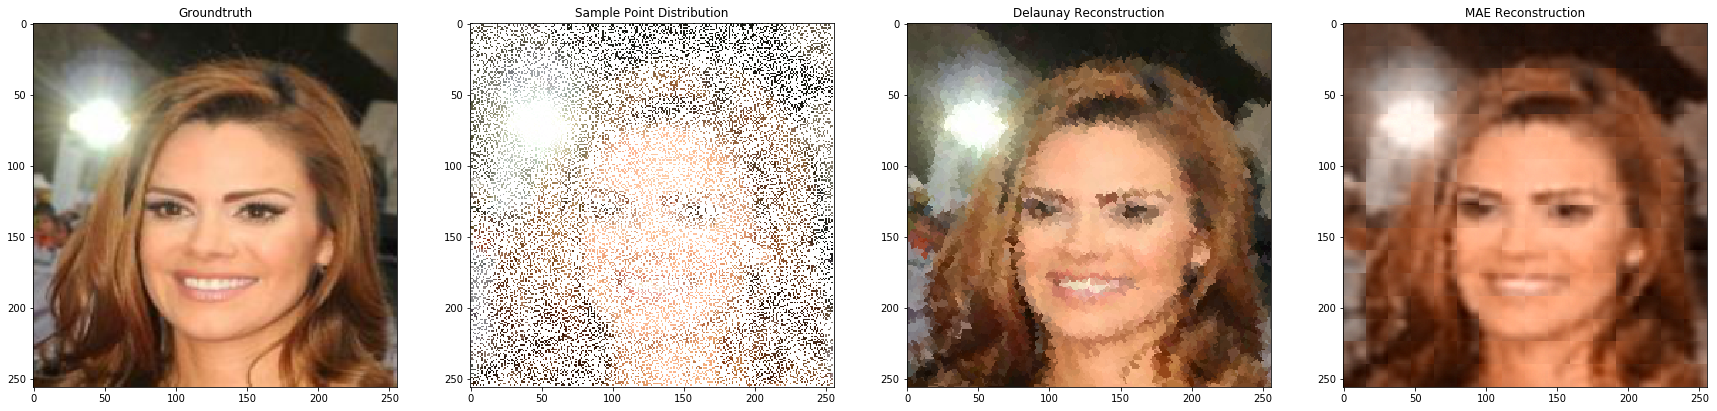

In [13]:
from utils import visualize_all

img_pair = normal_test_dataset[1]
x = img_pair['lr'].unsqueeze(0).permute(0, 3, 1, 2).to(device)
y = img_pair['hr'].unsqueeze(0).permute(0, 3, 1, 2).to(device)

print(x.shape, y.shape)

model.eval()
with torch.no_grad():
    output = model.forward_nomask(x)
    img_pred = output.permute(0, 2, 3, 1).cpu().numpy()[:, :, :, :-1][0]
    img_lr = x[0].permute(1, 2, 0).cpu().numpy()[:, :, :-1]
    img_hr = y[0].permute(1, 2, 0).cpu().numpy()
    # pred_mean = img_pred.mean(axis=(0, 1), keepdims=True)
    # pred_std = img_pred.std(axis=(0, 1), keepdims=True)
    # lr_mean = img_lr.mean(axis=(0, 1), keepdims=True)
    # lr_std = img_lr.std(axis=(0, 1), keepdims=True)
    # print(pred_mean)
    # print(lr_mean)
    # print(pred_std)
    # print(lr_std)
    # img_rebiased = (img_pred - pred_mean) /pred_std * lr_std + lr_mean

    
    
    # patch_h, patch_w = 16, 16
    # b, c, h, w = x.shape
    # num_patches = (h // patch_h) * (w // patch_w)
    # lr_patches = x.view(
    #     b, c,
    #     h // patch_h, patch_h,
    #     w // patch_w, patch_w
    # ) \
    # .permute(0, 2, 4, 3, 5, 1) \
    # .reshape(b, num_patches, -1)
    # #* (b, N_h, N_w, h_p*w_p*c)
    
    # pred_patches = output.view(
    #     b, c,
    #     h // patch_h, patch_h,
    #     w // patch_w, patch_w
    # ) \
    # .permute(0, 2, 4, 3, 5, 1) \
    # .reshape(b, num_patches, -1)
    figsize=(30, 30)
    plt.figure(1, figsize=figsize)
    plt.subplot(1, 4, 1)
    plt.imshow(img_hr)
    plt.title('Groundtruth')

    plt.figure(1, figsize=figsize)
    plt.subplot(1, 4, 2)
    plt.imshow(x[0].permute(1, 2, 0).cpu().numpy())
    plt.title('Sample Point Distribution')

    plt.figure(1, figsize=figsize)
    plt.subplot(1, 4, 3)
    plt.imshow(img_lr)
    plt.title('Delaunay Reconstruction')
    
    plt.figure(1, figsize=figsize)
    plt.subplot(1, 4, 4)
    plt.imshow(img_pred)
    plt.title('MAE Reconstruction')
    
    plt.show()
    # utils.show_gt_and_pred(x[0].permute(1, 2, 0).cpu().numpy(), img_lr, img_pred)
    
    

### Test Stage

In [74]:
model.eval()
tot_mse = 0
tot_psnr = 0
tot_ssim = 0

tot_lr_mse = 0
tot_lr_psnr = 0
tot_lr_ssim = 0

loop = tqdm.tqdm(normal_test_loader)
with torch.no_grad():
    for idx, img_pair in enumerate(loop):
        
        x = img_pair['lr'].to(device)
        output = model.forward_nomask(x)
        
        img_pred = output.permute(0, 2, 3, 1)[:, :, :, :-1].permute(0, 3, 1, 2).to(device)
        img_lr = img_pair['lr'].permute(0, 2, 3, 1)[:, :, :, :-1].permute(0, 3, 1, 2).to(device)
        img_hr = img_pair['hr'].to(device)
        
        # lr_mean = img_lr.mean(dim=(2, 3), keepdim=True)
        # lr_std = img_lr.std(dim=(2, 3), keepdim=True)
        # pred_mean = img_pred.mean(dim=(2, 3), keepdim=True)
        # pred_std = img_pred.std(dim=(2, 3), keepdim=True)
        
        # img_pred = img_pred - pred_mean + lr_mean
        # img_pred = (img_pred-pred_mean)/pred_std * lr_std + lr_mean
        
        mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_pred.reshape((img_hr.shape[0], -1)))
        psnr = utils.psnr(img_hr, img_pred)
        ssim = utils.ssim(img_hr, img_pred)
        loss = -psnr/300 - ssim + mse
        
        tot_mse += mse
        tot_psnr += psnr
        tot_ssim += ssim
        
        lr_psnr = utils.psnr(img_hr, img_lr)
        lr_ssim = utils.ssim(img_hr, img_lr)
        lr_mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_lr.reshape((img_hr.shape[0], -1)))
            
        tot_lr_mse += lr_mse
        tot_lr_psnr += lr_psnr
        tot_lr_ssim += lr_ssim
        
        loop.set_description(f"iter: {idx}/{len(normal_test_loader)} | loss: {loss.item()} | psnr improvement: {(tot_psnr-tot_lr_psnr)*100/tot_lr_psnr} | ssim improvement: {(tot_ssim-tot_lr_ssim)*100/tot_lr_ssim} | mse_decrease: {(tot_lr_mse-tot_mse)*100/tot_lr_mse}")
print(f"Avg.LR_PSNR: {tot_lr_psnr / len(normal_test_loader)} | Avg.LR_SSIM: {tot_lr_ssim / len(normal_test_loader)}")
print(f"Avg.PSNR: {tot_psnr / len(normal_test_loader)} | Avg.SSIM: {tot_ssim / len(normal_test_loader)}")

Error in callback <function _WandbInit._resume_backend at 0x7f8f7c99dcb0> (for pre_run_cell):


Exception: The wandb backend process has shutdown

  0%|          | 0/100 [00:00<?, ?it/s]/home/purewhite/anaconda3/envs/cs231n/lib/python3.7/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
iter: 99/100 | loss: -0.9013373851776123 | psnr improvement: 2.476022958755493 | ssim improvement: 13.212544441223145 | mse_decrease: 31.66205406188965: 100%|██████████| 100/100 [00:07<00:00, 12.72it/s] 

Avg.LR_PSNR: 68.55140686035156 | Avg.LR_SSIM: 0.6207754015922546
Avg.PSNR: 70.2487564086914 | Avg.SSIM: 0.7027956247329712
Error in callback <function _WandbInit._pause_backend at 0x7f8f7c939c20> (for post_run_cell):


Exception: The wandb backend process has shutdown

# Residual Experiment

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


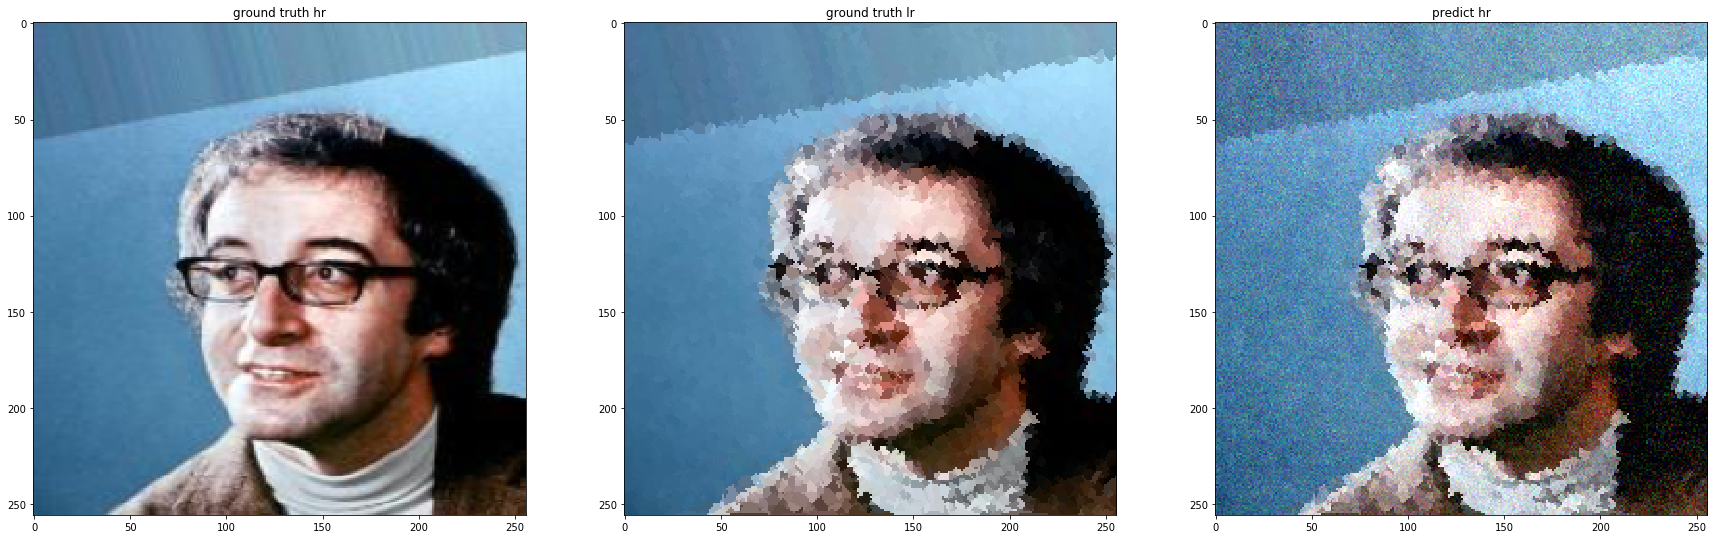

epoch: 19 | iter: 399/400 | loss: -0.521331250667572: 100%|██████████| 400/400 [03:07<00:00,  2.13it/s]  


In [10]:
model.load_state_dict(torch.load('/home/purewhite/workspace/cg-proj/NUG-DLSS/logs/MAE_pretrained.pth'))
args = parse_args(["--alg", "MAE", "--description", "mae_pretrain_piconly_residual", "--lr", "1e-3", "--epoch", "20", '--data_root', 'data/celeba', '--batch_size', '1'])

wandb.init(project="MAE-toy-finetune-residual-celebA-1000-12220110", entity="purewhite2019")
wandb.config = {
  "args" : args,
  "seed" : 31415926
}

utils.set_seed_everywhere(31415926)

# for _ in range(800): # Default setting in MAE paper
optimizer.zero_grad()
model.train()
wandb.watch(model)
for e in range(args.epoch):
    idx = random.randint(0, len(normal_train_dataset)-1)
    img_pair = utils.collect_function([normal_train_dataset[idx]])

    model.eval()
    clear()
    img_lr = img_pair['lr'].permute(0, 2, 3, 1).cpu().numpy()[:, :, :, :-1]
    img_hr = img_pair['hr'].permute(0, 2, 3, 1).cpu().numpy()
    with torch.no_grad():
        output = model.forward_nomask(img_pair['lr'].to(device))
        img_pred = output.permute(0, 2, 3, 1).cpu().numpy()[:, :, :, :-1]  + img_lr

    utils.show_gt_and_pred(img_hr=img_hr[0], img_lr=img_lr[0], pred_hr=img_pred[0], figsize=(30, 30))
    
    tot_mse = 0
    tot_psnr = 0
    tot_ssim = 0

    tot_lr_mse = 0
    tot_lr_psnr = 0
    tot_lr_ssim = 0
    
    model.train()
    loop = tqdm.tqdm(normal_train_loader)
    for idx, img_pair in enumerate(loop):
        
        img_lr = img_pair['lr'].permute(0, 2, 3, 1)[:, :, :, :-1].permute(0, 3, 1, 2).to(device)
        img_hr = img_pair['hr'].to(device)
        
        x = img_pair['lr'].to(device)
        output = model.forward_nomask(x)
        
        img_pred = output.permute(0, 2, 3, 1)[:, :, :, :-1].permute(0, 3, 1, 2).to(device) + img_lr
        
        mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_pred.reshape((img_hr.shape[0], -1)))
        psnr = utils.psnr(img_hr, img_pred)
        ssim = utils.ssim(img_hr, img_pred)
        loss = -psnr/300 - ssim + mse
        
        tot_mse += mse
        tot_psnr += psnr
        tot_ssim += ssim
        
        lr_psnr = utils.psnr(img_hr, img_lr)
        lr_ssim = utils.ssim(img_hr, img_lr)
        lr_mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_lr.reshape((img_hr.shape[0], -1)))
            
        tot_lr_mse += lr_mse
        tot_lr_psnr += lr_psnr
        tot_lr_ssim += lr_ssim
        
        loss = -psnr/300 - ssim + mse
            
        wandb.log({"psnr improvement": (psnr-lr_psnr)*100/lr_psnr})
        wandb.log({"ssim improvement": (ssim-lr_ssim)*100/lr_ssim})
        wandb.log({"mse improvement": (lr_mse-mse)*100/lr_mse})
        wandb.log({"psnr": psnr})
        wandb.log({"ssim": ssim})
        wandb.log({"mse": mse})
        wandb.log({"loss": loss})
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        loop.set_description(f"epoch: {e} | iter: {idx}/{len(train_dataset)} | loss: {loss.item()}")
    
    e += 1
    utils.save_model(model, e, args)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


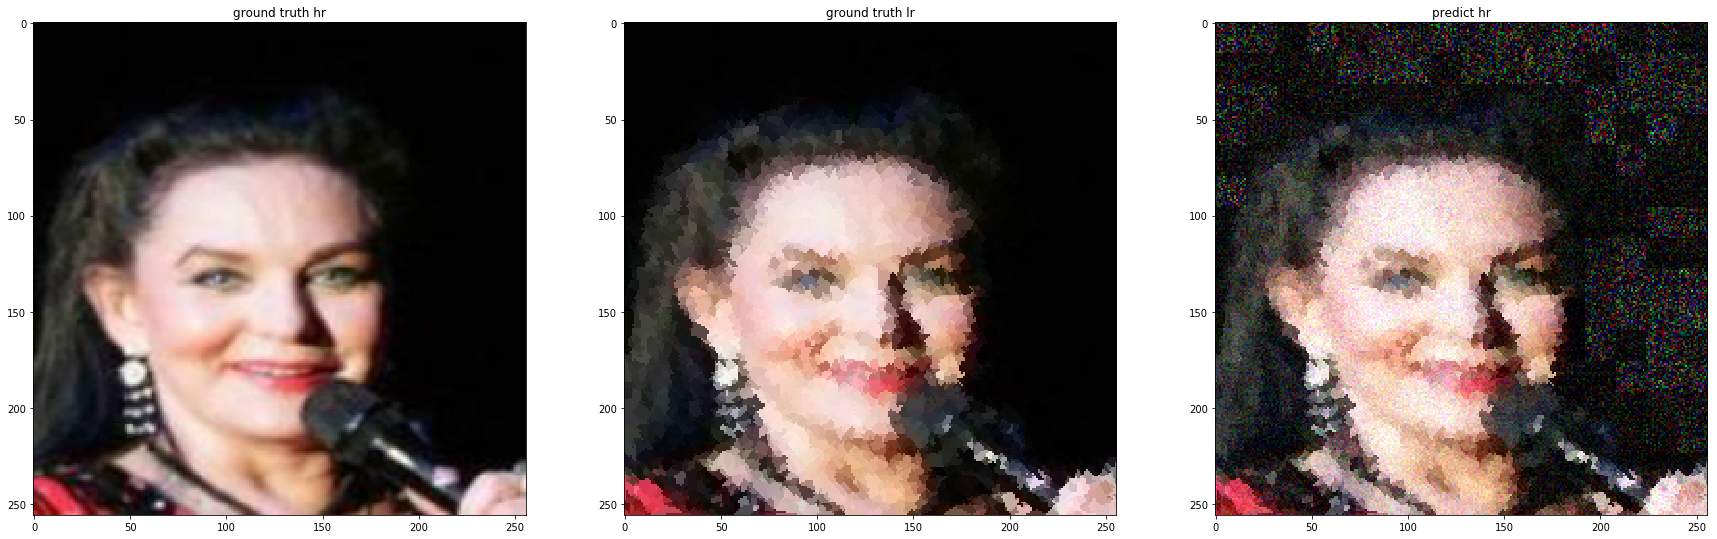

epoch: 39 | iter: 399/400 | loss: -0.5080257058143616: 100%|██████████| 400/400 [03:52<00:00,  1.72it/s] 


In [11]:
optimizer.zero_grad()
model.train()
wandb.watch(model)
for e in range(args.epoch, 2*args.epoch):
    idx = random.randint(0, len(normal_train_dataset)-1)
    img_pair = utils.collect_function([normal_train_dataset[idx]])

    model.eval()
    clear()
    img_lr = img_pair['lr'].permute(0, 2, 3, 1).cpu().numpy()[:, :, :, :-1]
    img_hr = img_pair['hr'].permute(0, 2, 3, 1).cpu().numpy()
    with torch.no_grad():
        output = model.forward_nomask(img_pair['lr'].to(device))
        img_pred = output.permute(0, 2, 3, 1).cpu().numpy()[:, :, :, :-1]  + img_lr

    utils.show_gt_and_pred(img_hr=img_hr[0], img_lr=img_lr[0], pred_hr=img_pred[0], figsize=(30, 30))
    
    tot_mse = 0
    tot_psnr = 0
    tot_ssim = 0

    tot_lr_mse = 0
    tot_lr_psnr = 0
    tot_lr_ssim = 0
    
    model.train()
    loop = tqdm.tqdm(normal_train_loader)
    for idx, img_pair in enumerate(loop):
        
        img_lr = img_pair['lr'].permute(0, 2, 3, 1)[:, :, :, :-1].permute(0, 3, 1, 2).to(device)
        img_hr = img_pair['hr'].to(device)
        
        x = img_pair['lr'].to(device)
        output = model.forward_nomask(x)
        
        img_pred = output.permute(0, 2, 3, 1)[:, :, :, :-1].permute(0, 3, 1, 2).to(device) + img_lr
        
        mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_pred.reshape((img_hr.shape[0], -1)))
        psnr = utils.psnr(img_hr, img_pred)
        ssim = utils.ssim(img_hr, img_pred)
        loss = -psnr/300 - ssim + mse
        
        tot_mse += mse
        tot_psnr += psnr
        tot_ssim += ssim
        
        lr_psnr = utils.psnr(img_hr, img_lr)
        lr_ssim = utils.ssim(img_hr, img_lr)
        lr_mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_lr.reshape((img_hr.shape[0], -1)))
            
        tot_lr_mse += lr_mse
        tot_lr_psnr += lr_psnr
        tot_lr_ssim += lr_ssim
        
        loss = -psnr/300 - ssim + mse
            
        wandb.log({"psnr improvement": (psnr-lr_psnr)*100/lr_psnr})
        wandb.log({"ssim improvement": (ssim-lr_ssim)*100/lr_ssim})
        wandb.log({"mse improvement": (lr_mse-mse)*100/lr_mse})
        wandb.log({"psnr": psnr})
        wandb.log({"ssim": ssim})
        wandb.log({"mse": mse})
        wandb.log({"loss": loss})
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        loop.set_description(f"epoch: {e} | iter: {idx}/{len(train_dataset)} | loss: {loss.item()}")
    
    e += 1
    utils.save_model(model, e, args)

In [8]:
wandb.init(project="MAE-toy-finetune-norm-celebA-1000-12220110", entity="purewhite2019")
wandb.config = {
  "args" : args,
  "seed" : 31415926
}

utils.set_seed_everywhere(31415926)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: purewhite2019 (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.9 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


In [23]:
x = torch.normal(-1.0, 5.0, (4, 3, 256, 256))
print(x.shape)
mean = x.mean(dim=(2,3), keepdim=True)
std = x.std(dim=(2,3), keepdim=True)
print(mean.shape, std.shape)
# print(mean)
# print(std)
y = (x - mean)
y = y / std
mean_y = y.mean(dim=(2,3))
std_y = y.mean(dim=(2,3))
print(y.shape, mean_y.shape, std_y.shape)
print(mean_y)
print(std_y)



torch.Size([4, 3, 256, 256])
torch.Size([4, 3, 1, 1]) torch.Size([4, 3, 1, 1])
torch.Size([4, 3, 256, 256]) torch.Size([4, 3]) torch.Size([4, 3])
tensor([[-6.0536e-09, -1.3737e-08, -6.2864e-09],
        [ 3.3004e-08,  6.9849e-10,  1.1642e-08],
        [-1.4552e-10, -1.3039e-08, -1.0361e-08],
        [-4.6566e-10,  7.6252e-09,  1.1059e-08]])
tensor([[-6.0536e-09, -1.3737e-08, -6.2864e-09],
        [ 3.3004e-08,  6.9849e-10,  1.1642e-08],
        [-1.4552e-10, -1.3039e-08, -1.0361e-08],
        [-4.6566e-10,  7.6252e-09,  1.1059e-08]])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


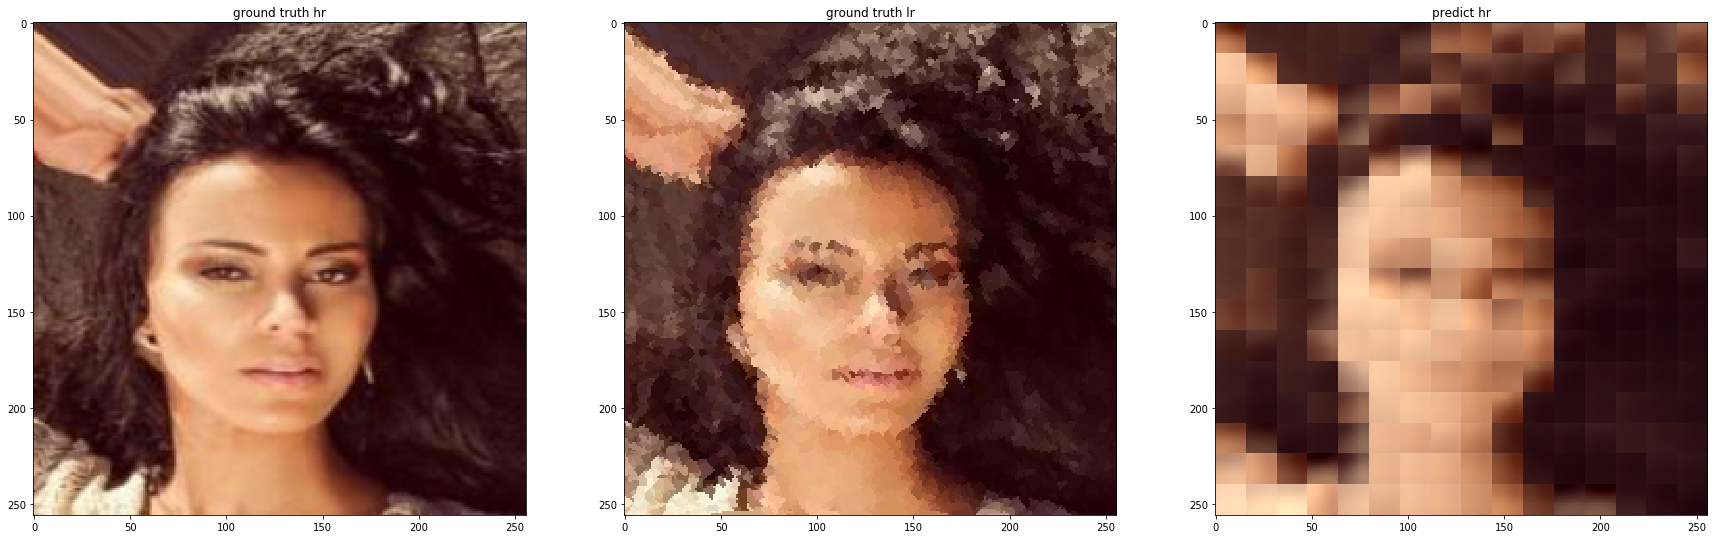

epoch: 6 | iter: 324/400 | loss: -0.7709029912948608:  81%|████████▏ | 325/400 [04:34<01:03,  1.18it/s]


KeyboardInterrupt: 

In [10]:
optimizer.zero_grad()
model.train()
wandb.watch(model)
for e in range(0, args.epoch):
    idx = random.randint(0, len(normal_train_dataset)-1)
    img_pair = utils.collect_function([normal_train_dataset[idx]])

    model.eval()
    clear()
    img_lr = img_pair['lr'].permute(0, 2, 3, 1).cpu().numpy()[:, :, :, :-1]
    img_hr = img_pair['hr'].permute(0, 2, 3, 1).cpu().numpy()
    with torch.no_grad():
        output = model.forward_nomask(img_pair['lr'].to(device))
        pred = output.permute(0, 2, 3, 1).cpu().numpy()[:, :, :, :-1]
        
        lr_mean = img_lr.mean(axis=(1,2), keepdims=True)
        lr_std = img_lr.std(axis=(1,2), keepdims=True)
        pred_mean = pred.mean(axis=(1,2), keepdims=True)
        pred_std = pred.std(axis=(1,2), keepdims=True)
        pred_norm = (pred - pred_mean) / pred_std
        img_pred = (pred_norm * lr_std) + lr_mean
        
    utils.show_gt_and_pred(img_hr=img_hr[0], img_lr=img_lr[0], pred_hr=img_pred[0], figsize=(30, 30))
    
    tot_mse = 0
    tot_psnr = 0
    tot_ssim = 0

    tot_lr_mse = 0
    tot_lr_psnr = 0
    tot_lr_ssim = 0
    
    model.train()
    loop = tqdm.tqdm(normal_train_loader)
    for idx, img_pair in enumerate(loop):
        
        img_lr = img_pair['lr'].permute(0, 2, 3, 1)[:, :, :, :-1].permute(0, 3, 1, 2).to(device)
        img_hr = img_pair['hr'].to(device)
        
        x = img_pair['lr'].to(device)
        output = model.forward_nomask(x)
        
        pred = output.permute(0, 2, 3, 1)[:, :, :, :-1].permute(0, 3, 1, 2).to(device)
        
        lr_mean = img_lr.mean(dim=(2,3), keepdim=True)
        lr_std = img_lr.std(dim=(2,3), keepdim=True)
        pred_mean = pred.mean(dim=(2,3), keepdim=True)
        pred_std = pred.std(dim=(2,3), keepdim=True)
        pred_norm = (pred - pred_mean) / pred_std
        img_pred = (pred_norm * lr_std) + lr_mean
        
        mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_pred.reshape((img_hr.shape[0], -1)))
        psnr = utils.psnr(img_hr, img_pred)
        ssim = utils.ssim(img_hr, img_pred)
        loss = -psnr/300 - ssim + mse
        
        tot_mse += mse
        tot_psnr += psnr
        tot_ssim += ssim
        
        lr_psnr = utils.psnr(img_hr, img_lr)
        lr_ssim = utils.ssim(img_hr, img_lr)
        lr_mse = F.mse_loss(img_hr.reshape((img_hr.shape[0], -1)), img_lr.reshape((img_hr.shape[0], -1)))
            
        tot_lr_mse += lr_mse
        tot_lr_psnr += lr_psnr
        tot_lr_ssim += lr_ssim
        
        loss = -psnr/300 - ssim + mse
            
        wandb.log({"psnr improvement": (psnr-lr_psnr)*100/lr_psnr})
        wandb.log({"ssim improvement": (ssim-lr_ssim)*100/lr_ssim})
        wandb.log({"mse improvement": (lr_mse-mse)*100/lr_mse})
        wandb.log({"psnr": psnr})
        wandb.log({"ssim": ssim})
        wandb.log({"mse": mse})
        wandb.log({"loss": loss})
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        loop.set_description(f"epoch: {e} | iter: {idx}/{len(normal_train_loader)} | loss: {loss.item()}")
    
    utils.save_model(model, e, args)